In [1]:
from bias_tree import BiasDetectionTree, get_metric_bias_tree_for_model
from data_preparation.movielens_100k import MovieLens100KData
from recommender.surprise_recommender import random_search_fit_surprise_recommendation_model
import pandas as pd
import surprise

### Prepare training data

In [2]:
data = MovieLens100KData(data_path='data/ml-100k')
X_train, X_test = data.get_data_splits_for_training(use_val_set=False)

### Train CF models and tune their hyperparameters

In [3]:
MODEL_GRID =[(surprise.SVD,  {'biased': [True, False], 'n_factors': [ 10, 20, 50], 
            'n_epochs': [5, 20, 50],
                           'reg_all': [0.01, 0.06, 0.1],
     'lr_all': [0.001, 0.005, 0.01],
    }),
               (surprise.NMF, {'biased': [True, False], 'n_factors': [ 10, 20, 50], 'n_epochs': [5, 20, 50],
                           'reg_pu': [0.01, 0.06, 0.1], 'reg_qi': [0.01, 0.06, 0.1],
    'reg_bu': [0.02, 0.06, 0.1],
    'reg_bi': [0.02, 0.06, 0.1],
    'lr_bu': [0.001, 0.005, 0.01],
     'lr_bi': [0.001, 0.005, 0.01],}),
    (surprise.CoClustering,    {'n_cltr_u': [3, 5, 10, 20, 30, 50, 100], 'n_cltr_i': [3, 5, 10, 20, 30, 50, 100]}),
(surprise.KNNWithMeans, {'user_based': [True, False], 'k': [5, 10, 20, 50, 100],}), 
# (KNNWithZScore, {'user_based': [True, False], 'k': [5, 10, 20, 50, 100],}), 
                (surprise.SlopeOne, {}),
            ]

SVD
{'biased': True, 'n_factors': 20, 'n_epochs': 50, 'reg_all': 0.1, 'lr_all': 0.01}
<class 'surprise.prediction_algorithms.matrix_factorization.SVD'>
{'rmse': 0.9233368994827114, 'mae': 0.7282832945025071}
root=[]: 0.852
├── year_bucketized=['high']: 0.984
│   ├── user activity_bucketized=['high', 'medium']: 0.874
│   └── user activity_bucketized=['low']: 1.065
├── year_bucketized=['low']: 0.764
│   ├── gender=['F']: 0.89
│   └── gender=['M']: 0.725
│       ├── item popularity_bucketized=['high']: 0.674
│       └── item popularity_bucketized=['low', 'medium']: 0.76
└── year_bucketized=['medium']: 0.864
    ├── gender=['F']: 0.968
    └── gender=['M']: 0.828
        ├── item popularity_bucketized=['high', 'medium']: 0.777
        └── item popularity_bucketized=['low']: 0.906

{"year_bucketized": ["high"], "user activity_bucketized": ["low"]} 1.065
NMF
{'biased': False, 'n_factors': 50, 'n_epochs': 50, 'reg_pu': 0.1, 'reg_qi': 0.1, 'reg_bu': 0.06, 'reg_bi': 0.02, 'lr_bu': 0.001, 'lr_bi

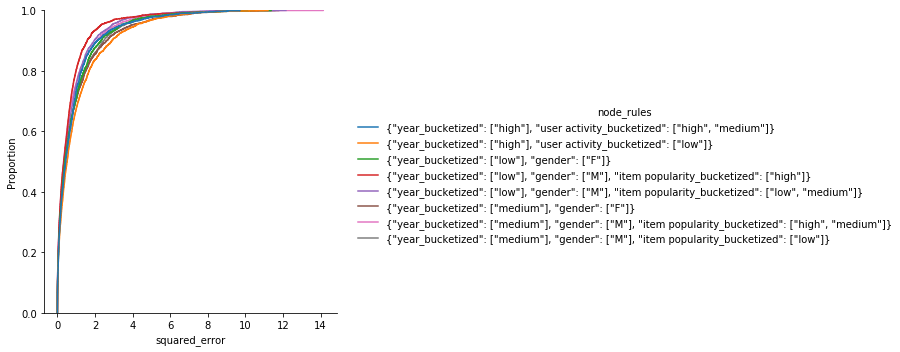

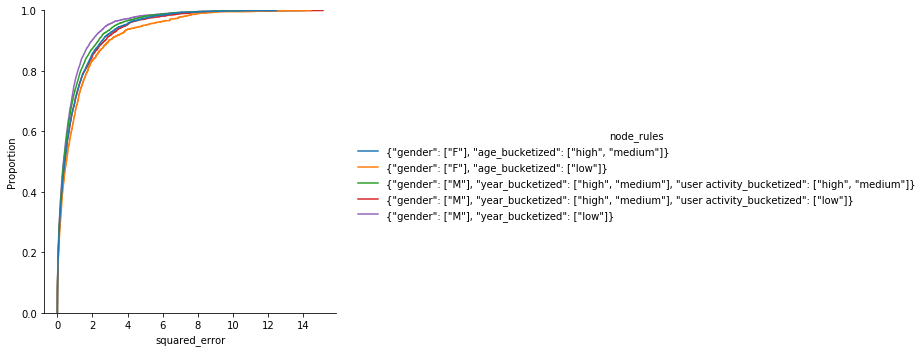

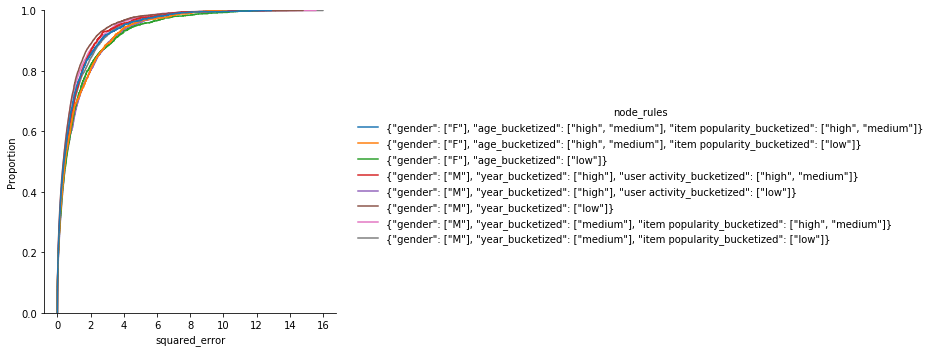

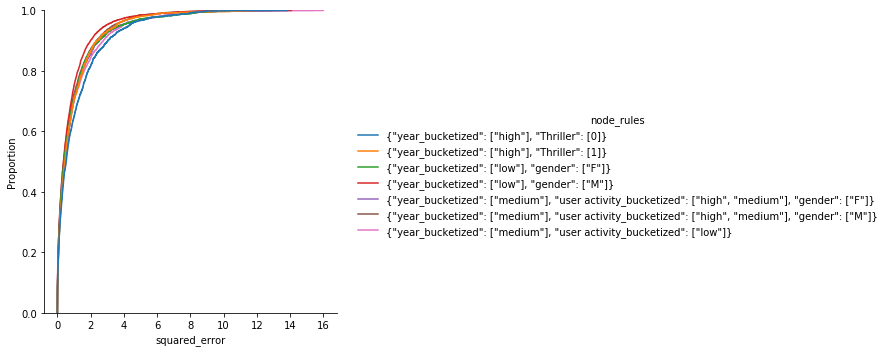

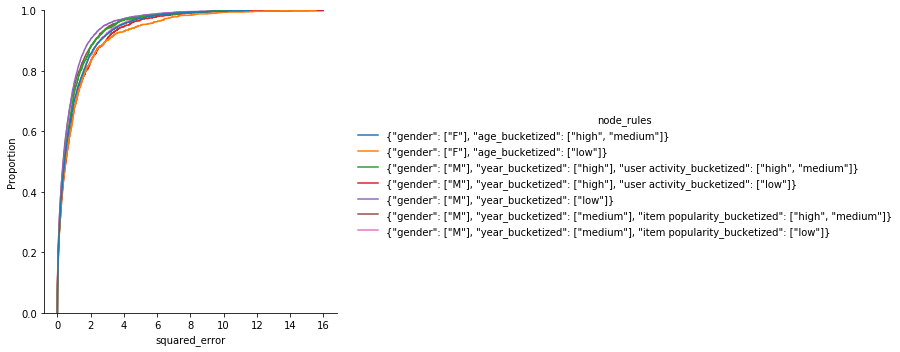

In [4]:
N_ITER = 10
MIN_CHILD_NODE_SIZE = 1000
METRIC = 'squared_error'

leaf_metrics_models = []
avg_metric = {}

for model_cls, grid in MODEL_GRID:
    print('-----------------')
    print(model_cls.__name__)
    model = random_search_fit_surprise_recommendation_model(X_train, model_cls, grid, n_iter=N_ITER)
    bias_tree_test = get_metric_bias_tree_for_model(model, X_test, data.attributes_dict, 
                                                 metric_name=METRIC,
                                                min_child_node_size=MIN_CHILD_NODE_SIZE)
    avg_metric[model_cls.__name__] = X_test[METRIC].mean()
    model_leaf_metrics = bias_tree_test.leaf_metrics
    model_leaf_metrics['model'] = model_cls.__name__
    leaf_metrics_models.append(model_leaf_metrics)
    print("Most biased leaf: ", bias_tree_test.max_metric_node, round(bias_tree_test.max_metric_value, 3))

### Select  model with fairness objective

In [22]:
avg_metrics_pd = pd.Series(avg_metric)
display(avg_metrics_pd.sort_values())
best_model_global = avg_metrics_pd.idxmin()

SVD             0.851713
NMF             0.896342
SlopeOne        0.909561
KNNWithMeans    0.917802
CoClustering    0.959094
dtype: float64

In [25]:
leaf_metrics_models_pd = pd.concat(leaf_metrics_models)
metrics_global_max_bias = leaf_metrics_models_pd.groupby('model').max()['mean'].to_frame().join(avg_metrics_pd.to_frame())
metrics_global_max_bias.columns=['max bias', 'global']

In [30]:
FAIRNESS_ALPHA = 0.5
metrics_global_max_bias['weighted_fair_metric'] = FAIRNESS_ALPHA * metrics_global_max_bias['max bias'] \
                                                    + (1-FAIRNESS_ALPHA)* metrics_global_max_bias['global']

In [31]:
metrics_global_max_bias['weighted_fair_metric'].sort_values()

model
SVD             0.958388
KNNWithMeans    1.021806
NMF             1.023951
SlopeOne        1.035447
CoClustering    1.077008
Name: weighted_fairn_metric, dtype: float64